In [1]:
from torch_snippets import *

In [2]:
trn_df = pd.read_csv('fairface-label-train.csv')
val_df = pd.read_csv('fairface-label-val.csv')
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [3]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def __len__(self): return len(self.df)
    
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = read(file, 1)
        return im, age, gen

    def preprocess_image(self, im):
        im = resize(im, IMAGE_SIZE)
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im[None]

    def collate_fn(self, batch):
        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im)

            ages.append(float(int(age)/80))
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)

        return ims, ages, genders

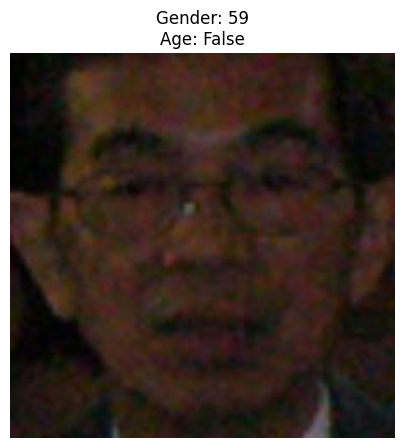

In [4]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)
im, gen, age = trn[0]
show(im, title=f'Gender: {gen}\nAge: {age}', sz=5)

In [5]:
train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

ims, gens, ages = next(iter(train_loader))
inspect(ims, gens, ages)

Tensor	Shape: torch.Size([32, 3, 224, 224])	Min: -2.118	Max: 2.640	Mean: -0.345	dtype: torch.float32
Tensor	Shape: torch.Size([32])	Min: 0.062	Max: 0.863	Mean: 0.357	dtype: torch.float32
Tensor	Shape: torch.Size([32])	Min: 0.000	Max: 1.000	Mean: 0.344	dtype: torch.float32


In [6]:
from torchvision import models
def get_model():
    model = models.vgg16(pretrained = True)
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age
        
    model.classifier = ageGenderClassifier()
    
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)
    
    return model.to(device), loss_functions, optimizer

model, loss_functions, optimizer = get_model()

In [7]:
from torchsummary import summary
summary(model, input_size=(3,224,224), device=device);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       (1,792)
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       (36,928)
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       (73,856)
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       (147,584)
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      (295,168)
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      (590,080)
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      (590,080)
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      (1,180,160)
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-

In [8]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)    
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

def validate_batch(data, model, criteria):
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
        pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss, gender_acc, age_mae

EPOCH: 1.000	trn_loss: 0.547	val_loss: 0.460	val_gender_acc: 0.836	val_age_mae: 6.089	(493.14s - 1972.57s remaining)
EPOCH: 2.000	trn_loss: 0.399	val_loss: 0.452	val_gender_acc: 0.840	val_age_mae: 6.220	(977.46s - 1466.19s remaining)
EPOCH: 3.000	trn_loss: 0.282	val_loss: 0.505	val_gender_acc: 0.842	val_age_mae: 6.256	(1461.27s - 974.18s remaining)
EPOCH: 4.000	trn_loss: 0.196	val_loss: 0.624	val_gender_acc: 0.843	val_age_mae: 6.417	(1944.94s - 486.24s remaining)
EPOCH: 5.000	trn_loss: 0.157	val_loss: 0.707	val_gender_acc: 0.830	val_age_mae: 6.268	(2428.37s - 0.00s remaining)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 220.78it/s]


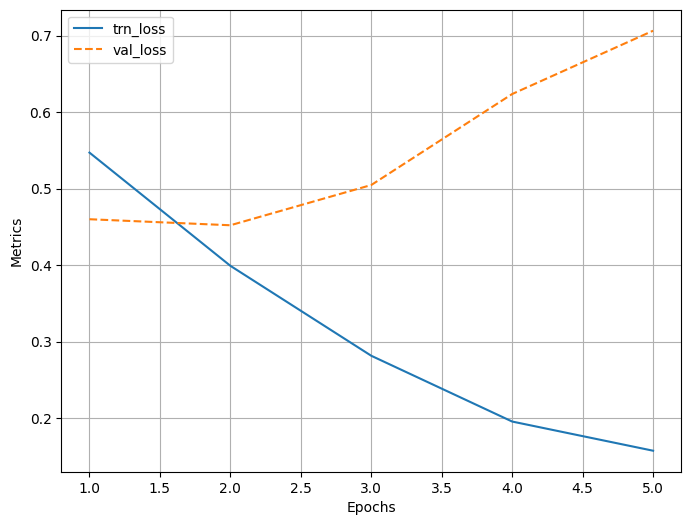

In [9]:
model, criterion, optimizer = get_model()
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(train_loader)
    for ix, data in enumerate(train_loader):
        if ix==N: break
        total_loss = train_batch(data, model, optimizer, criterion)
        log.record(epoch+(ix+1)/N, trn_loss=total_loss, end='\r')

    N = len(test_loader)
    for ix, data in enumerate(test_loader):
        if ix==N: break
        total_loss, gender_acc, age_mae = validate_batch(data, model, criterion)
        gender_acc /= len(data[0])
        age_mae /= len(data[0])
        log.record(epoch+(ix+1)/N, val_loss=total_loss, val_gender_acc=gender_acc, val_age_mae=age_mae, end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['trn_loss', 'val_loss'])

predicted gender: Female ; Predicted age 24


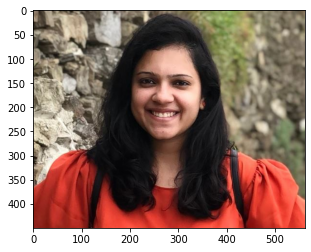

In [11]:
%matplotlib inline
im = cv2.imread('./5_9.jpeg')
im = trn.preprocess_image(im).to(device)
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

im = cv2.imread('./5_9.jpeg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'), '; Predicted age', int(pred_age[0][0]*80))